<a href="https://colab.research.google.com/github/juhosattila/nn_tdk/blob/master/NLTV_L1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage import color
from skimage.io import imread
#from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

In [8]:
from google.colab import files
uploaded = files.upload()

Saving abdo-ct-ped.jpg to abdo-ct-ped.jpg


In [0]:
image_orig = mpimg.imread('abdo-ct-ped.jpg')

In [0]:
plt.imshow(image_orig)
print(image_orig.shape)
print(color.rgb2gray(image_orig).shape)

In [0]:
image_gray = color.rgb2gray(image_orig)

# Pad with zeros to get equal sizes.
image = np.zeros((max(image_orig.shape), max(image_orig.shape)))
c = ( int((image.shape[0]-image_orig.shape[0]) / 2), int((image.shape[1]-image_orig.shape[1]) / 2))
image[c[0]:c[0]+image_orig.shape[0], c[1]:c[1]+image_orig.shape[1]] = image_gray

(422, 422)


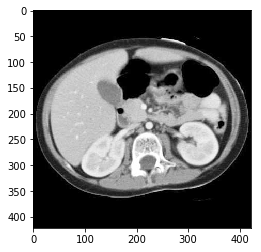

In [12]:
plt.imshow(image, cmap=plt.cm.Greys_r)
print(image.shape)

In [23]:
#theta = np.linspace(0., 180., max(image.shape), endpoint=False)
theta = np.linspace(0., 180., 60, endpoint=False)

# I0 = 1e5
# sigma = np.sqrt(1e1)
# eps = sigma * 1e-2

#sinogram = radon(image, theta=theta, circle=True)
sinogram_orig = radon(image, theta=theta, circle=True)

# I = I0 * np.exp(-sinogram_orig)# + np.random.normal(scale=sigma, size=sinogram_orig.shape)
# # I[I <= eps] = eps
# # print(I.size)
# # print(I[I <= eps].size)
# #I[I >= eps] += np.random.poisson(I[I >= eps])
# I = np.random.poisson(I)
# sinogram = np.log(I0 / I)

#I[I <= eps] = 0

# I[I >= sigma] += np.random.poisson(I[I >= sigma])
# sinogram = np.log(I0 / I)

#sinogram = sinogram_orig + np.random.normal(scale=sigma, size=sinogram_orig.shape)
# sinogram[sinogram < sigma] = 0
# sinogram[sinogram >= sigma] += np.random.poisson(sinogram[sinogram >= sigma])
# sinogram = sinogram_poisson

# np.min(I[I >= sigma])

I0 = 1e5
sigma = 5e-2

I = I0 * np.exp(-sinogram_orig)
I += np.random.normal(scale=sigma * I)
print(I[I <= 0].size)
I[I <= 0] = 1e-4
sinogram = np.log(I0 / I)

/usr/local/lib/python3.6/dist-packages/skimage/transform/radon_transform.py:63: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


0


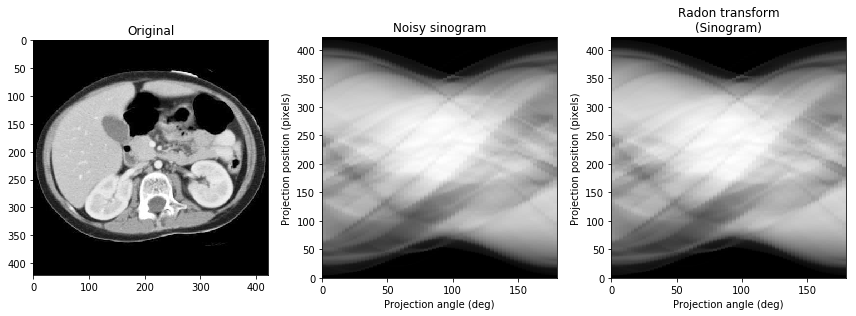

0.05027935678664525


In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

ax2.set_title("Noisy sinogram")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

ax3.set_title("Radon transform\n(Sinogram)")
ax3.set_xlabel("Projection angle (deg)")
ax3.set_ylabel("Projection position (pixels)")
ax3.imshow(sinogram_orig, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram_orig.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

print(np.std(sinogram-sinogram_orig))

Reconstruction with the Filtered Back Projection (FBP)
======================================================

In [0]:
from skimage.transform import iradon

FBP rms reconstruction error: 0.0453


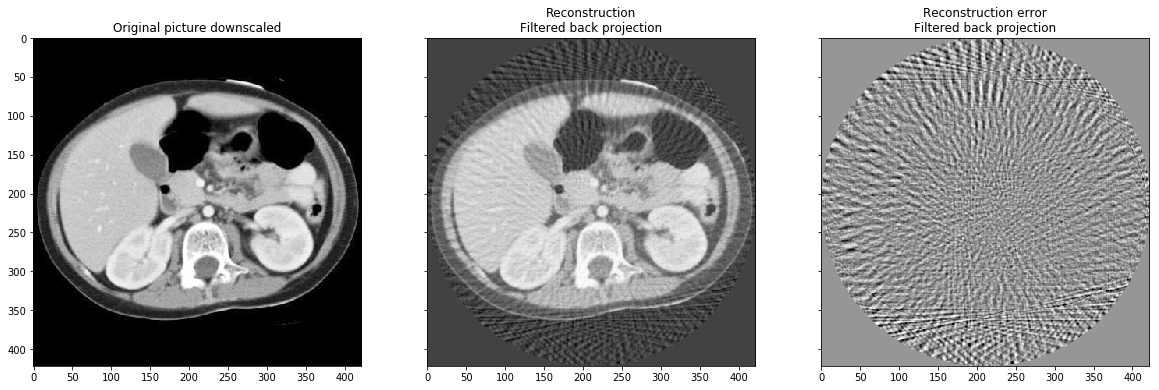

In [25]:
reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error = reconstruction_fbp - image
print(f"FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}")

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 24),
                               sharex=True, sharey=True)
ax0.set_title("Original picture downscaled")
ax0.imshow(image, cmap=plt.cm.Greys_r)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

Reconstruction with the Simultaneous Algebraic Reconstruction Technique
=======================================================================




In [0]:
from skimage.transform import iradon_sart
import math

SART (1 iteration) rms reconstruction error: 0.0431
SART (2 iterations) rms reconstruction error: 0.0291
SART (3 iterations) rms reconstruction error: 0.0257
SART (4 iterations) rms reconstruction error: 0.0252


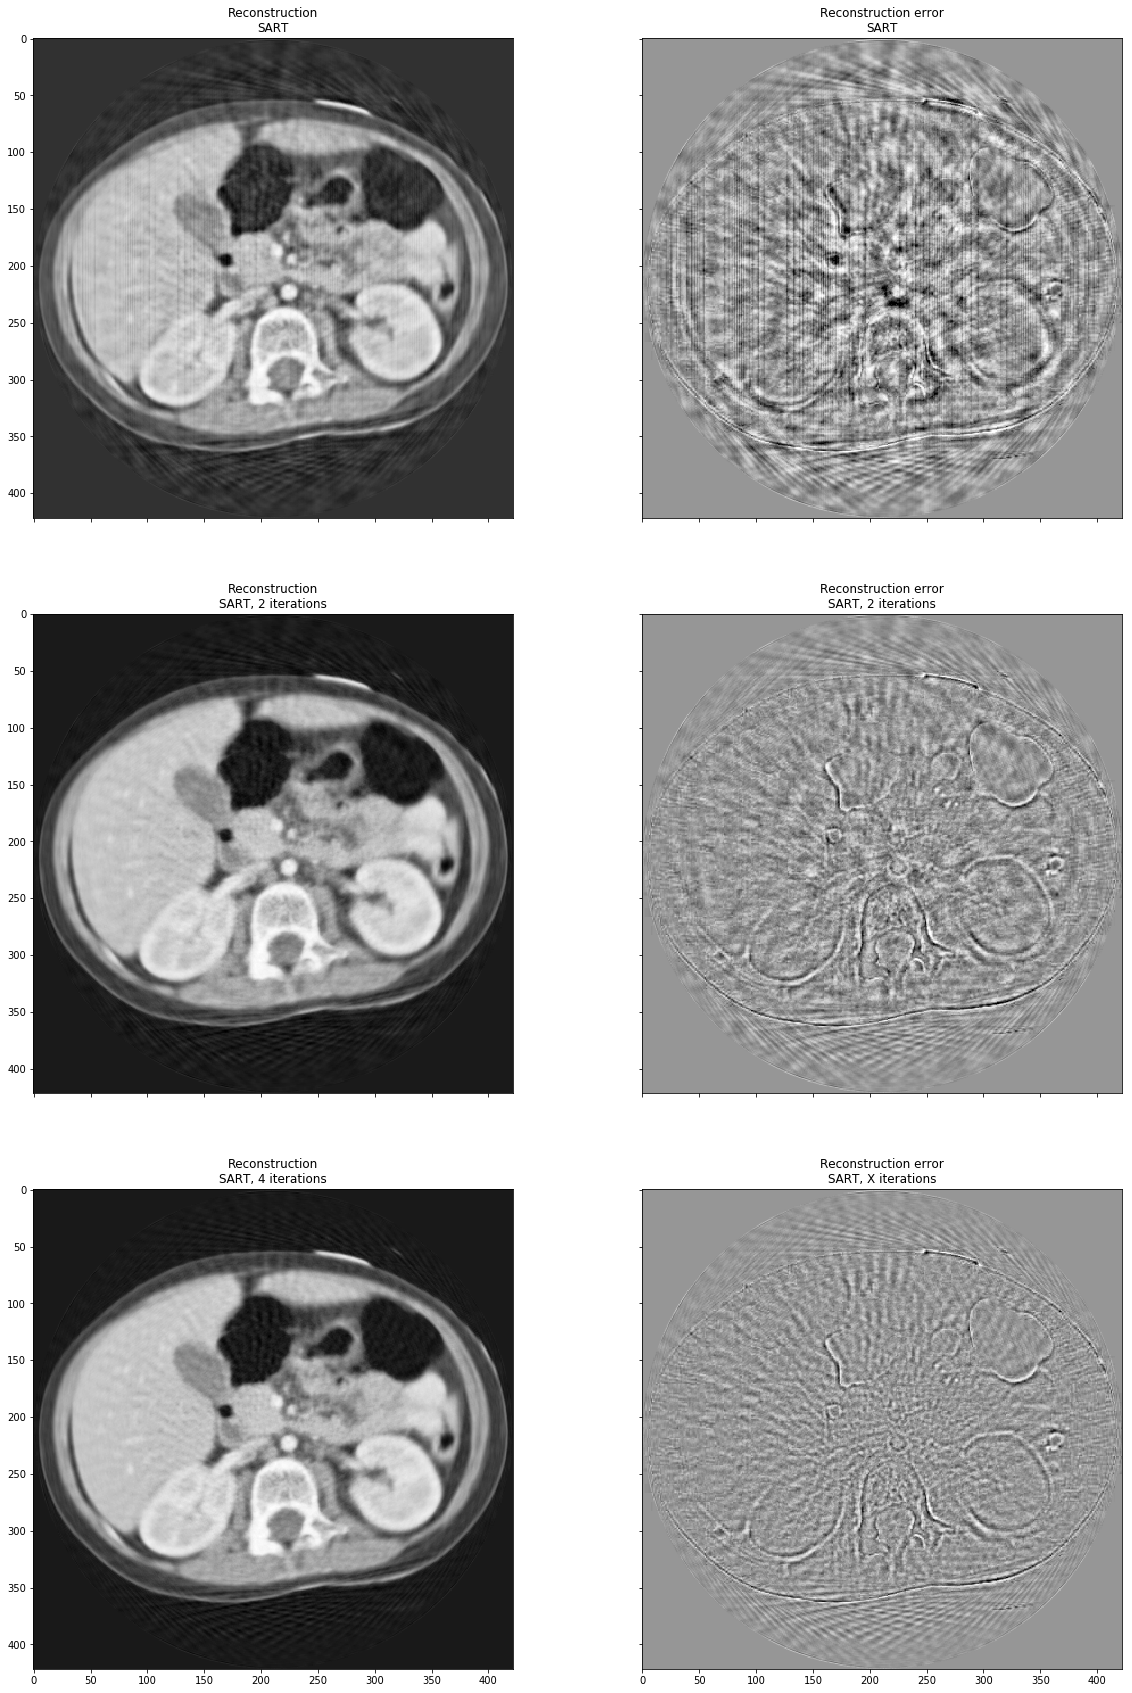

In [29]:
relaxation = 0.6
nr_of_iterations = 4
is_momentum = False
alfa_momentum = 0.2
max_early_stopping = 2

reconstruction_sart = iradon_sart(sinogram, theta=theta, relaxation=relaxation)
error = reconstruction_sart - image
print("SART (1 iteration) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

fig, axes = plt.subplots(3, 2, figsize=(20, 30), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[1].set_title("Reconstruction error\nSART")
ax[1].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r, **imkwargs)

# Run a second iteration of SART by supplying the reconstruction
# from the first iteration as an initial estimate
reconstruction_sart2 = iradon_sart(sinogram, theta=theta,
                                   image=reconstruction_sart, relaxation=relaxation)
error = reconstruction_sart2 - image
print("SART (2 iterations) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

ax[2].set_title("Reconstruction\nSART, 2 iterations")
ax[2].imshow(reconstruction_sart2, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error\nSART, 2 iterations")
ax[3].imshow(reconstruction_sart2 - image, cmap=plt.cm.Greys_r, **imkwargs)

nr_of_iterations = 4
iteration_sart = reconstruction_sart2.copy()

if is_momentum:
  iteration_sart_previous = iteration_sart.copy()  
  previous_error = math.inf

early_stopping_counter = 0

for i in range(3, nr_of_iterations + 1):    
    if is_momentum == False:
      iteration_sart = iradon_sart(sinogram, theta = theta, image=iteration_sart, relaxation=relaxation)
    else:
      previous_direction = iteration_sart - iteration_sart_previous
      iteration_sart_previous = iteration_sart.copy()
      iteration_sart = iradon_sart(sinogram, theta = theta,
                                   image=iteration_sart + previous_direction * alfa_momentum,
                                   relaxation=relaxation)
    
    error = np.sqrt(np.mean((iteration_sart-image)**2))
    print(f"SART ({i} iterations) rms reconstruction error: {error:.3g}")
    if(previous_error < error):
        early_stopping_counter += 1
        if early_stopping_counter == max_early_stopping:
            break
    else: early_stopping_counter = 0
    previous_error = error

reconstruction_sartX = iteration_sart

ax[4].set_title(f"Reconstruction\nSART, {nr_of_iterations} iterations")
ax[4].imshow(reconstruction_sartX, cmap=plt.cm.Greys_r)

ax[5].set_title("Reconstruction error\nSART, X iterations")
ax[5].imshow(reconstruction_sartX - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()